You Only Look Once，你只需要看一次，不需要先看框，再看類別，一次滿足檢測的所有需求。目前(20220902)已經發展到YOLOv7，雖然我還在弄v3，但相信資料格式是差不多的。相信，，即使有所落差，看完我的處理方式的說明，應該還是可以輕易的上手的。

在下已有翻譯相關YOLO的論文，可參考[連結](https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FHy6kUMWNI)，主要參考程式碼為[git_japap](https://github.com/jmpap/YOLOV2-Tensorflow-2.0)與[YunYang1994](https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/299fd6689f242d0f647a96b8844e86325e9fcb46/4-Object_Detection/YOLOV3/core/dataset.py)

首先，我們要先取得資料集，會使用[Pascal VOC 2007的資料集](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html)，內有訓練、驗證、與測試三個子集。再請自行至上面連結內下載資料集即可。當然如果你使用的是另外的資料集，像是COCO的話，那就自己再找找COCO的部份就行。特別注意到類別數量的部份可能有所不同就是。

解開tar之後，相關檔案會存在於資料夾VOCdevkit底下。不過就自己記得兩資料夾再解開，不然資料會混在一起。當然這個是看你介不介意，理論上是無所謂，因為文件內就有可以協助分離資料集的資料。

這邊假設你已經看過Arch_YOLO_dataset_preprocess_1並且已瞭解，因此相關的註解都會拿掉以維護版面整潔

首先載入需求套件

In [1]:
import os

import xml.etree.ElementTree as ET
import xmltodict
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf


設置一下label的對應

In [2]:
VOC_NAME_LABEL_CLASS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

In [3]:
VOC_NAME_LABEL = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}
VOC_LABEL_NAME = {v[0]:key for key,v in VOC_NAME_LABEL_CLASS.items()}

載入取得照片bbox的函數

In [4]:
def get_imgs_bounding_box(ann_folder, img_folder, label_mapping, is_difficult=False):
    """將Annotations的xml轉為訓練資料格式
    :param ann_folder: Annotations資料夾路徑
    :param img_folder: 照片資料夾路徑
    :param label_mapping: label的描述與索引關聯表
    :param is_difficult: 是否排除標記為困難的框
    
    returns
        imgs_name: 所有照片的完整路徑
        true_boxes: 所有照片的每一個邊界框的物件資訊
    """     
    # 記錄所有照片的完整路徑
    imgs_name = []
    # 記錄照片的所有bound boxes
    imgs_boxes = []
    # 記錄一張照片中最多框有多少個
    max_count = 0  
    
    # 取得所有xml檔案
    for ann in os.listdir(ann_folder):    
        # 記錄單張照片有幾個框
        bound_box_count = 0
        
        # 取讀檔案
        file = open(os.path.join(ann_folder, ann))
        dict_ann_data = xmltodict.parse(file.read(), force_list=True)['annotation'][0]
        file.close()
        
        # 開始處理資料格式
        # 這邊不做一些是否存在的判斷，直接假設你的資料都是符合資料格式
        # 記錄照片完整路徑
        imgs_name.append(os.path.join(img_folder, dict_ann_data["filename"][0]))        
        
        # 記錄照片的width、height
        w = int(dict_ann_data['size'][0]['width'][0])
        h = int(dict_ann_data['size'][0]['height'][0])        
        
        # 記錄照片中所有的物件資訊
        boxes = []

        # 判斷是否存在物件，有些照片可能只有背景
        # 不存在物件就直接解析下一個xml檔案
        if 'object' not in dict_ann_data:            
            continue       

        for obj in dict_ann_data['object']:
            bound_box_count += 1
            
            # 判斷是否處理難處理照片            
            difficult = bool(int(obj['difficult'][0]))
            if difficult and is_difficult:
                continue
                
            # 記錄照片中物件的資訊
            # xmin、ymin、xmax、ymax、object label
            # 座標點縮放
            box = np.zeros((5))
            box[0] = float(obj['bndbox'][0]['xmin'][0]) / w
            box[1] = float(obj['bndbox'][0]['ymin'][0]) / h
            box[2] = float(obj['bndbox'][0]['xmax'][0]) / w
            box[3] = float(obj['bndbox'][0]['ymax'][0]) / h
            box[4] = int(label_mapping[obj['name'][0]])
            boxes.append(box)               

        # 記錄一張照片中最大框的數量
        if bound_box_count > max_count:
            max_count = bound_box_count            
        
        imgs_boxes.append(np.asarray(boxes))

    # 將照片的完整路徑list轉為numpy
    imgs_name = np.array(imgs_name)

    # 開一張大表要拿來寫入我們所取得的所有邊界框資訊
    # 其維度為(照片量, 最大框數, 5)
    # 5就是xmin, ymin, xmax, ymax, label
    true_boxes = np.zeros((imgs_name.shape[0], max_count, 5))

    for idx, boxes in enumerate(imgs_boxes):
        true_boxes[idx, :boxes.shape[0], :5] = boxes

    return imgs_name, true_boxes

設置路徑並測試我們載入的函數是否正常執行

In [5]:
path = '/tf/tf2/VOC2007/VOCdevkit/VOC2007'
ann_folder = os.path.join(path, 'Annotations')
img_folder = os.path.join(path, 'JPEGImages')
label_mapping = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}

In [6]:
%%time
imgs_name, true_boxes = get_imgs_bounding_box(ann_folder, img_folder, label_mapping)

CPU times: user 3.4 s, sys: 130 ms, total: 3.53 s
Wall time: 3.53 s


In [7]:
imgs_name.shape, true_boxes.shape

((9963,), (9963, 42, 5))

下面載入照片生成器

In [8]:
def img2tensor(filename, true_boxes, h, w, channels=3):
    """將照片路徑轉為tensor"""    
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=channels)
    img = tf.image.convert_image_dtype(img, tf.float32)   
    img = tf.image.resize(img, (h, w))
    return img, true_boxes

In [9]:
def get_dataset(imgs_name, true_boxes, h, w, batch_size=5, shuffle=3000, seed=10):
    """生成tf.data.Dataset
    執行之前應該先從get_imgs_bounding_box取得照片路徑清單與實際框的資訊
    
    :params: imgs_name: 照片路徑清單
    :params: true_boxes: 照片內的邊界框資訊
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    :params: batch_size: 每次取批數量，預設為5
    :params: shuffle_num: 打散的數量，預設為3000
    :params: seed: 亂數種子，預設為10
    
    return
        dataset: ((batch_size x h x w x channel), (batch_size, max_bboxes, 5))
    """
    dataset = tf.data.Dataset.from_tensor_slices((imgs_name, true_boxes))
    # 資料轉型別
    dataset = dataset.map(lambda x, y: img2tensor(x, y, h=h, w=w))
    # 資料打散
    dataset = dataset.shuffle(3000, seed=seed)
    # 資料要重覆
    dataset = dataset.repeat()
    # 設置每批數量
    # 這可以自己利用參數來設置
    dataset = dataset.batch(batch_size)
    # 設置預取
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

產生資料生成器

In [10]:
datasets = get_dataset(imgs_name, true_boxes, 416, 416, batch_size=5)

測試配合生成器繪製框確認是否正確

In [11]:
def plot_dataset(datasets, h, w, version=False):
    """隨機取一張照片出來繪製
    
    請先利用get_dataset取得dataset
    
    :params: datasets: 從get_dataset取得的dataset
    :params: h: 預計resize的照片高度
    :params: w: 預計resize的照片寬度
    :params: version: 是否顯示簡單訊息
    """
    for data in datasets.take(1):
        fig = plt.figure(figsize=(16, 9))
        img = data[0][0]    
        f, ax = plt.subplots(1, 1)
        ax.imshow(img)
        objects = (data[1][0]).numpy()
        # 一張照片上可能有多個物件，因此要迴圈處理    
        for idx in range(objects.shape[0]):
            obj = objects[idx]
            if obj[-1] == 0.:
                # 沒物件的時候就直接中斷迴圈
                break        
            # tensor to numpy
            
            _x = obj[0] * w
            _y = obj[1] * h
            _w = (obj[2] * w) - (obj[0] * w)
            _h = (obj[3] * h) - (obj[1] * h)
            _label = obj[4]

            # 畫方框
            rect = patches.Rectangle((_x, _y), 
                                     _w, 
                                     _h, 
                                     linewidth=2, 
                                     facecolor='none', 
                                     edgecolor='red')                
            ax.add_patch(rect)
            ax.text(x=_x, y=_y, s=VOC_LABEL_NAME[_label], color='red')
            
            if version:
                print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}, label= {VOC_LABEL_NAME[_label]}')        
        
        plt.show()
        # 只需要一張，因此一次迭代就中斷
        break
    

<Figure size 1152x648 with 0 Axes>

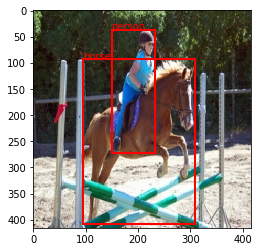

In [12]:
plot_dataset(datasets, 416, 416)

前置作業不少，下面這邊正式開始處理提供YOLOv3的資料格式

我們知道，YOLOv3是在不同尺度中各利用三個anchor boxes prior做為計算依據，所以我們就來設置一下，值得注意的是，我的[參考資料](https://github.com/YunYang1994/TensorFlow2.0-Examples/blob/299fd6689f242d0f647a96b8844e86325e9fcb46/4-Object_Detection/YOLOV3/core/dataset.py)中有為anchor boxes做縮放，猜測這是為了能夠適應不同大小的情況所做的設置，畢竟你可能會有自己想做的input、output之類的，不過一樣的，為了方便理解，這邊就採用預設情況。

In [13]:
# 下面註解給出的就是參考來源對於anchor box prior的一個縮放處理
# 1.25,1.625, 2.0,3.75, 4.125,2.875, 1.875,3.8125, 3.875,2.8125, 3.6875,7.4375, 3.625,2.8125, 4.875,6.1875, 11.65625,10.1875
# [8, 16, 32]
anchors='10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape((3, 3, 2))
anchors

array([[[ 10.,  13.],
        [ 16.,  30.],
        [ 33.,  23.]],

       [[ 30.,  61.],
        [ 62.,  45.],
        [ 59., 119.]],

       [[116.,  90.],
        [156., 198.],
        [373., 326.]]])

In [14]:
ANCHORS = anchors.copy()
# 這是跟上面ANCHORS對應的STRIDES
STRIDES = [8, 16, 32]

<img src="https://hackmd.io/_uploads/ByAPjJkli.png" width="50%" />

STRIDES的話，該怎麼說，我們假設，上面是一張200x200的照片，那中心點也就是(100, 100)的地方有一個框的大小是100x100，結果來看我們的output會是一個5x5x1x(5+C)的tensor。我們幻想的是，一張輸入的照片被我們切割成5x5，那每個grid cell就代表200/5=40的大小。如果你用sliding window來思考的話，你就是拿著一個40x40的章在蓋。那100x100要蓋幾次，蓋2.5次，也就是100/40=2.5。所以你用40x40的角度來看100x100的框，它就是一個2.5x2.5的框。不過這部份還是要看整體程式碼的單位定義就是。

根據Arch_YOLOv3_3_loss_function裡面的decoder函數我們知道，這個decoder是會將output的feature map轉為一個M x N x N x 3 x (5 + class nums)，這是一個已經經過計算之後得到的推論資料，而我們上面的資料生成器是一個經過正規化的資料，這是為了能夠適應轉成不同大小所做的設置，先把這事放心裡。

YOLOv3的input shape我們假定為(416, 416, 3)，然後output會有三種不同尺度的資料，我們先拿一個尺度(13 x 13)來做說明，剩下的只是迴圈處理的問題。

In [15]:
input_shape = 416
output_shape = 416 / np.array(STRIDES)
output_shape 

array([52., 26., 13.])

我們的資料生成器已經會提供我們正規化過後的照片還有照片上面的所有的框資訊，因為我們的batch size是5，所以生成器回傳的第一個索引資料維度就會是照片資訊(5, 416, 416, 3)，第二個索引資料維度就會是照片上的框資訊(5, 42, 5)，如果你不明白42這個數字怎麼來的話可以回頭看一下preprocess_1。

In [16]:
for data in datasets.take(1):
    print(data[0].shape)
    print(data[1].shape)
    break

(5, 416, 416, 3)
(5, 42, 5)


瞭解輸出資訊的維度之後就可以來做後續的處理

首先開張表來等著記錄每一張照片上的每一個anchor box的資訊

In [17]:
label_true_box = np.zeros(shape=(5, 13, 13, 3, 5 + 21))
label_true_box.shape

(5, 13, 13, 3, 26)

再開一張表來記錄照片的所有bounding box資訊

In [18]:
label_img_bbox = np.zeros(shape=(5, 42, 4))

In [19]:
label_true_box = np.zeros(shape=(5, 13, 13, 3, 5 + 21))
label_img_bbox = np.zeros(shape=(5, 42, 4))

# 取1個batch size的資料，也就是5筆
for data in datasets.take(1):
    # 1個batch有5張照片
    for i in range(5):
        # 邊界框的資訊先轉為numpy
        bboxes = data[1][i].numpy()
        # 遍歷所有的邊界框
        for idx, bbox in enumerate(bboxes):
            # 沒有物件的時候就直接中斷
            if bbox[4] == 0:
                break
            # 這邊的資訊是正規化後的資訊
            # 計算寬、高
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            # 取得中心點
            cx = (bbox[0] + bbox[2]) / 2
            cy = (bbox[1] + bbox[3]) / 2
            print(f'bbox: {idx}')
            print(f'original box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')            

            # 因為我們的資料是正規化處理過的
            # 所以這邊會根據實際的input shape做縮放
            w *= 416
            h *= 416
            cx *= 416
            cy *= 416
            print(f'rescale box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
        
            # 記錄這個batch的第i筆資料的第j個邊界框資訊            
            label_img_bbox[i, idx] =  np.array([cx, cy, w, h])                    
            
            # 接著，我們要計算中心點是落在那一個cell           
            cell_col = np.floor(cx / 32).astype(np.int)
            cell_row = np.floor(cy / 32).astype(np.int)                           
            print(f'cell col: {cell_col}, cell row: {cell_row}')
        
            # 現在我們要找出擁有最高iou的那個anchor box            
            # 這邊我還不是那麼確定，每個anchor box prior的中心點是跟物件的中心一致，
            # 還是每個grid cell的中心點才是anchor box prior的中心點
            # 取出anchor box的寬與高
            anchors_w = ANCHORS[2, :, 0] 
            anchors_h = ANCHORS[2, :, 1]           
            print(f'anchors_w: {anchors_w}, anchors_h: {anchors_h}')
        
            # 首先計算交集的面積
            intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
            print(f'intersect: {intersect}')
            # 接著計算聯集的區域面積
            # 兩個面積相加再減掉交集的面積
            union = (anchors_w * anchors_h) + (w * h) - intersect
            print(f'union: {union}')
            # 計算iou
            iou = intersect / union
            print(f'iou: {iou}')
        
            anchor_best = np.max(iou)
            # 最大iou的index
            anchor_best_idx = np.argmax(iou) 
            print(f'best anchor: {anchor_best}')
            print(f'best anchor idx: {anchor_best_idx}')
        
            # 記錄產品類別
            label_true_box[i,cell_col, cell_row, anchor_best_idx, 0: 4] = [cx, cy, w, h]
            label_true_box[i,cell_col, cell_row, anchor_best_idx, 4: 5] = 1
            label_true_box[i,cell_col, cell_row, anchor_best_idx, 5 + int(bbox[4])] = 1
            print(f'label_true_box: {label_true_box[i,cell_col, cell_row, anchor_best_idx]}')
        break

bbox: 0
original box: w:0.576, h: 0.9626666666666667, cx: 0.446, cy: 0.5186666666666667
rescale box: w:239.61599999999999, h: 400.46933333333334, cx: 185.536, cy: 215.76533333333336
cell col: 5, cell row: 6
anchors_w: [116. 156. 373.], anchors_h: [ 90. 198. 326.]
intersect: [10440.    30888.    78114.816]
union: [ 95958.859776  95958.859776 139442.043776]
iou: [0.10879662 0.32188794 0.56019558]
best anchor: 0.5601955757725683
best anchor idx: 2
label_true_box: [185.536      215.76533333 239.616      400.46933333   1.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           1.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]
bbox: 1
original box: w:0.5619999999999999, h: 0.6986666666666667, cx: 0.449, cy: 0.6506666666666667
rescale box: w:233.79199999999997, h: 290.6453333333333, cx: 186.784, cy: 270.67733333333337
cell col: 5, cell row: 8
anchors_w: 

基本上，目前我不是那麼確定anchor box prior的中心點是不是都一定在每個grid cell的中心點，如果是在grid cell的中心點的話，那IoU的計算就不是那麼簡單了，但我現在的作法是假定anchor box prior的中心點跟物體在該grid cell的中心點一致。

下面也可以看一下記錄照片所有bounding box的label_img_bboxes

In [20]:
label_img_bbox[0, 0: 2]

array([[185.536     , 215.76533333, 239.616     , 400.46933333],
       [186.784     , 270.67733333, 233.792     , 290.64533333]])

單一個尺度(13x13)沒問題之後，我們就可以嚐試加入其它尺度(26x26、52x52)來考慮，基本上我們要注意的就是，在不同尺度的情況下要正確取得相對應的anchor box prior就可以了。

In [21]:
label_true_boxes = [np.zeros(shape=(5, int(i), int(i), 3, 5 + 21)) for i in output_shape]
label_true_boxes[0].shape, label_true_boxes[1].shape, label_true_boxes[2].shape

((5, 52, 52, 3, 26), (5, 26, 26, 3, 26), (5, 13, 13, 3, 26))

In [22]:
label_img_bboxes = [np.zeros(shape=(5, 42, 4)) for _ in range(3)]
label_img_bboxes[0].shape, label_img_bboxes[1].shape, label_img_bboxes[2].shape

((5, 42, 4), (5, 42, 4), (5, 42, 4))

In [23]:
label_true_boxes = [np.zeros(shape=(5, int(i), int(i), 3, 5 + 21)) for i in output_shape]
label_img_bboxes = [np.zeros(shape=(5, 42, 4)) for _ in range(3)]

# 下面迴圈簡單說就是每一批照片中的每一張照片的每一個框都針對三種不同尺度來做處理
# 取1個batch size的資料，也就是5筆
for data in datasets.take(1):
    # 1個batch有5張照片
    for i in range(5):
        # 邊界框的資訊先轉為numpy
        bboxes = data[1][i].numpy()
        # 遍歷所有的邊界框
        for idx, bbox in enumerate(bboxes):
            # 沒有物件的時候就直接中斷
            if bbox[4] == 0:
                break
            # 這邊的資訊是正規化後的資訊
            # 計算寬、高
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            # 取得中心點
            cx = (bbox[0] + bbox[2]) / 2
            cy = (bbox[1] + bbox[3]) / 2
            print(f'bbox: {idx}')
            print(f'normalization box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')            

            # 因為我們的資料是正規化處理過的
            # 所以這邊會根據實際的input shape做縮放
            w *= 416
            h *= 416
            cx *= 416
            cy *= 416
            print(f'rescale box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
            # 三種anchor box prior尺度
            for output_idx, oshape in enumerate(output_shape):            
                print(f'output shape: {oshape}')

                # 在output_idex對應的維度記錄這個batch的第i筆資料的第j個邊界框資訊            
                label_img_bboxes[output_idx][i, idx] =  np.array([cx, cy, w, h])                    

                # 接著，我們要計算中心點是落在那一個cell           
                cell_col = np.floor(cx / STRIDES[output_idx]).astype(np.int)
                cell_row = np.floor(cy / STRIDES[output_idx]).astype(np.int)                           
                print(f'stride: {STRIDES[output_idx]}, cell col: {cell_col}, cell row: {cell_row}')

                # 現在我們要找出擁有最高iou的那個anchor box            
                # 這邊我還不是那麼確定，每個anchor box prior的中心點是跟物件的中心一致，
                # 還是每個grid cell的中心點才是anchor box prior的中心點
                # 取出anchor box的寬與高
                anchors_w = ANCHORS[output_idx, :, 0] 
                anchors_h = ANCHORS[output_idx, :, 1]           
                print(f'anchors_w: {anchors_w}, anchors_h: {anchors_h}')

                # 首先計算交集的面積
                intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
                print(f'intersect: {intersect}')
                # 接著計算聯集的區域面積
                # 兩個面積相加再減掉交集的面積
                union = (anchors_w * anchors_h) + (w * h) - intersect
                print(f'union: {union}')
                # 計算iou
                iou = intersect / union
                print(f'iou: {iou}')

                anchor_best = np.max(iou)
                # 最大iou的index
                anchor_best_idx = np.argmax(iou) 
                print(f'best anchor: {anchor_best}')
                print(f'best anchor idx: {anchor_best_idx}')

                # 在相對應維度的表中記錄產品類別
                label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 0: 4] = [cx, cy, w, h]
                label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 4: 5] = 1
                label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 5 + int(bbox[4])] = 1
                print(f'label_true_boxes: {label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx]}')
        break

bbox: 0
normalization box: w:0.29800000000000004, h: 0.36533333333333334, cx: 0.655, cy: 0.5533333333333333
rescale box: w:123.96800000000002, h: 151.97866666666667, cx: 272.48, cy: 230.18666666666667
output shape: 52.0
stride: 8, cell col: 34, cell row: 28
anchors_w: [10. 16. 33.], anchors_h: [13. 30. 23.]
intersect: [130. 480. 759.]
union: [18840.49134933 18840.49134933 18840.49134933]
iou: [0.00690003 0.02547704 0.04028557]
best anchor: 0.04028557355150172
best anchor idx: 2
label_true_boxes: [272.48       230.18666667 123.968      151.97866667   1.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   1.           0.           0.           0.           0.
   0.        ]
output shape: 26.0
stride: 16, cell col: 17, cell row: 14
anchors_w: [30. 62. 59.], anchors_h: [ 61.  45. 119.]
intersect: [1830. 2790. 7021.]
union: [18840.49134933 18840.49134933 18840.4913493

上面資料不難看出一個問題，就是大框套在小物件跟小框套在大物件的情況下，它的IoU是非常糟的，所以這種情況下我們只能利用閥值來做排除，參考來源中設置的是0.3(當然也可以用參數來做為控制)，但也要注意一件事，就是閥值排除之後有物件變成沒有物件，所以三個尺度迴圈處理完之後還要再做一次判定就是。

下面我們加入閥值做為調整

In [24]:
label_true_boxes = [np.zeros(shape=(5, int(i), int(i), 3, 5 + 21)) for i in output_shape]
label_img_bboxes = [np.zeros(shape=(5, 42, 4)) for _ in range(3)]

# 下面迴圈簡單說就是每一批照片中的每一張照片的每一個框都針對三種不同尺度來做處理
# 取1個batch size的資料，也就是5筆
for data in datasets.take(1):
    # 1個batch有5張照片
    for i in range(5):
        # 邊界框的資訊先轉為numpy
        bboxes = data[1][i].numpy()
        # 遍歷所有的邊界框
        for idx, bbox in enumerate(bboxes):                       
            # 沒有物件的時候就直接中斷
            if bbox[4] == 0:
                break
            print(f'object number: {bbox[4]}')
            # 用來記錄三個尺度的九個ancbor box比對出來的iou
#             iou_list = []
            # flag，用於記錄是不是有大於閥值的IoU
            flag_positive = False            
            # 過程中記錄一下當下最佳的那個iou，比對之後直接寫入好像好過再重計算一次？
            _pre_iou = 0.
            _biggest_iou_info = []
            
            # 這邊的資訊是正規化後的資訊
            # 計算寬、高
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            # 取得中心點
            cx = (bbox[0] + bbox[2]) / 2
            cy = (bbox[1] + bbox[3]) / 2
            print(f'bbox: {idx}')
            print(f'normalization box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')            

            # 因為我們的資料是正規化處理過的
            # 所以這邊會根據實際的input shape做縮放
            w *= 416
            h *= 416
            cx *= 416
            cy *= 416
            print(f'rescale box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')
            # 三種anchor box prior尺度
            for output_idx, oshape in enumerate(output_shape):            
                print(f'output shape: {oshape}')
                                
                # 在output_idex對應的維度記錄這個batch的第i筆資料的第j個邊界框資訊            
                label_img_bboxes[output_idx][i, idx] =  np.array([cx, cy, w, h])                      
                    
                # 接著，我們要計算中心點是落在那一個cell           
                cell_col = np.floor(cx / STRIDES[output_idx]).astype(np.int)
                cell_row = np.floor(cy / STRIDES[output_idx]).astype(np.int)                           
                print(f'stride: {STRIDES[output_idx]}, cell col: {cell_col}, cell row: {cell_row}')

                # 現在我們要找出擁有最高iou的那個anchor box            
                # 這邊我還不是那麼確定，每個anchor box prior的中心點是跟物件的中心一致，
                # 還是每個grid cell的中心點才是anchor box prior的中心點
                # 取出anchor box的寬與高
                anchors_w = ANCHORS[output_idx, :, 0] 
                anchors_h = ANCHORS[output_idx, :, 1]           
                print(f'anchors_w: {anchors_w}, anchors_h: {anchors_h}')

                # 首先計算交集的面積
                intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
                print(f'intersect: {intersect}')
                # 接著計算聯集的區域面積
                # 兩個面積相加再減掉交集的面積
                union = (anchors_w * anchors_h) + (w * h) - intersect
                print(f'union: {union}')
                # 計算iou
                iou = intersect / union
                print(f'iou: {iou}')
                
                # 寫入記錄做為後續如果真的真的真的沒有一個框是超過閥值的話
                # 我們就從裡面挑一個最大的來當做代表吧
#                 iou_list.append(iou)
                
                anchor_best = np.max(iou)
                # 最大iou的index
                anchor_best_idx = np.argmax(iou)                 
                print(f'best anchor: {anchor_best}')
                print(f'best anchor idx: {anchor_best_idx}')
                
                if anchor_best > _pre_iou:                    
                    _pre_out = anchor_best
                    _biggest_iou_info = [output_idx, cell_col, cell_row, anchor_best_idx]
                    print(f'anchor_best change: {_biggest_iou_info}.')
                
                # 如果最好的IoU超過閥值，那就在相對應維度的表中記錄產品類別
                if anchor_best >= 0.3:  
                    # 如果有超過閥值的flag_positive面就不用再做其它處理
                    flag_positive = True                                        
                    
                    label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 0: 4] = [cx, cy, w, h]
                    label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 4: 5] = 1
                    label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 5 + int(bbox[4])] = 1
                    print(f'label_true_boxes: {label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx]}')
                    
                    
                else:
                    print(f'output shape: {oshape} no IoU over 30%')
                    
            # 這邊我們在一張照片三種尺度處理之後如果還是沒有超過30%閥值的要處理一下
            # 參考來源是在最後如果都沒有的話再做一次全數的整理，不過我個人的認為是過程中只是比較
            # 也許效能上是比較不耗計算資源，畢竟只是比較，比完記錄這樣
            if not flag_positive:
                print('no IoU over 30%, so get the biggest IoU.')
                label_true_boxes[_biggest_iou_info[0]][i, _biggest_iou_info[1], _biggest_iou_info[2], _biggest_iou_info[3], 0: 4] = [cx, cy, w, h]
                
        break

object number: 13.0
bbox: 0
normalization box: w:0.07799999999999996, h: 0.35200000000000004, cx: 0.5429999999999999, cy: 0.5253333333333333
rescale box: w:32.44799999999998, h: 146.43200000000002, cx: 225.88799999999998, cy: 218.53866666666667
output shape: 52.0
stride: 8, cell col: 28, cell row: 27
anchors_w: [10. 16. 33.], anchors_h: [13. 30. 23.]
intersect: [130.    480.    746.304]
union: [4751.425536 4751.425536 4764.121536]
iou: [0.02736021 0.10102231 0.15665092]
best anchor: 0.15665091546480642
best anchor idx: 2
anchor_best change: [0, 28, 27, 2].
output shape: 52.0 no IoU over 30%
output shape: 26.0
stride: 16, cell col: 14, cell row: 13
anchors_w: [30. 62. 59.], anchors_h: [ 61.  45. 119.]
intersect: [1830.    1460.16  3861.312]
union: [4751.425536 6081.265536 7911.113536]
iou: [0.38514757 0.24010792 0.48808704]
best anchor: 0.48808704140433123
best anchor idx: 2
anchor_best change: [1, 14, 13, 2].
label_true_boxes: [225.888      218.53866667  32.448      146.432        1.
 

看起來資料的產出應該是沒問題，現在我們可以把這個過程函數化，想控的部份就可以利參數來處理，參數看起來可能會有點多，這是為了方便說明使用，如果真的要上線的話，不是弄個class，就是弄個參數檔

In [56]:
def generate_data_for_loss(data_generator, batch_size: int, max_bboxes: int, class_nums: int, 
                           anchor_prior_nums: int=3, output_shape: np.ndarray=np.array([52., 26., 13.]),
                           version=False, testing=False):
    """生成yolov3用於計算loss的資料格式
    data_generator: tensor data的資料生成器
    batch_size: 每次訓練張數
    max_bboxes: 資料集中，一張照片最多有幾個框的數量
    class_nums: 類別數量
    anchor_prior_nums: 每個尺度使用的anchor prior nums的數量，標準的話會是3個
    output_shape: yolov3的輸出大小，標準的話會是[52, 26, 13]
    version: 是否列印過程中的訊息
    testing: 測試用取一筆就結束
    
    return 
        label_true_boxes: 各尺度上的物件資料對應
            三個索引分別為：52x52、26x26、13x13
            維度為batch_size x anchor_scale x anchor_scale x anchor_box_prior_nums x (5 + class nums)
        label_img_bboxes: 照片上的各物件的xywh
            維度為batch_size x max_object_in_image x 4
    """        
    label_true_boxes = [np.zeros(shape=(batch_size, int(i), int(i), 3, 5 + class_nums)) for i in output_shape]
    label_img_bboxes = [np.zeros(shape=(batch_size, max_bboxes, 4)) for _ in range(anchor_prior_nums)]

    for data in data_generator.take(1):
        for i in range(batch_size):            
            bboxes = data[1][i].numpy()                        
            for idx, bbox in enumerate(bboxes):                                       
                _message = []            
                
                if bbox[4] == 0:
                    break
                    
                _message.append(f'batch size: {i}, bbox nums: {idx}, object class number: {bbox[4]}')

                _one_hot_class = np.zeros(shape=(class_nums), dtype=np.float)
                _one_hot_class[int(bbox[4])] = 1.0
                
                flag_positive = False            

                _pre_iou = 0.
                _biggest_iou_info = []

                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                cx = (bbox[0] + bbox[2]) / 2
                cy = (bbox[1] + bbox[3]) / 2
                _message.append(f'bbox nums: {idx}, normalization box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')                
                
                w *= 416
                h *= 416
                cx *= 416
                cy *= 416
                _message.append(f'bbox nums: {idx}, rescale box: w:{w}, h: {h}, cx: {cx}, cy: {cy}')       
                                
                for output_idx, oshape in enumerate(output_shape):                                                                
                    label_img_bboxes[output_idx][i, idx] =  np.array([cx, cy, w, h])                      
                    
                    cell_col = np.floor(cx / STRIDES[output_idx]).astype(np.int)
                    cell_row = np.floor(cy / STRIDES[output_idx]).astype(np.int)                                               
                    _message.append(f'anchor scale: {oshape}, stride: {STRIDES[output_idx]}, cell col: {cell_col}, cell row: {cell_row}')
                    
                    anchors_w = ANCHORS[output_idx, :, 0] 
                    anchors_h = ANCHORS[output_idx, :, 1]           
                    _message.append(f'anchor scale: {oshape}, stride: {STRIDES[output_idx]}, anchors_w: {anchors_w}, anchors_h: {anchors_h}')
                    
                    intersect = np.minimum(w, anchors_w) * np.minimum(h, anchors_h)
                    union = (anchors_w * anchors_h) + (w * h) - intersect
                    iou = intersect / union                                        
                    _message.append(f'intersect: {intersect}')
                    _message.append(f'union: {union}')
                    _message.append(f'iou: {iou}')
                    
                    anchor_best = np.max(iou)                    
                    anchor_best_idx = np.argmax(iou)                 
                    _message.append(f'best anchor: {anchor_best}, best anchor idx: {anchor_best_idx}')                                        

                    if anchor_best > _pre_iou:                    
                        _pre_out = anchor_best
                        _biggest_iou_info = [output_idx, cell_col, cell_row, anchor_best_idx]                        
                    
                    if anchor_best >= 0.3:  
                        flag_positive = True                                        
                        label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 0: 4] = [cx, cy, w, h]
                        label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 4: 5] = 1
                        #label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 5 + int(bbox[4])] = 1
                        label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx, 5:] = _one_hot_class
                        _message.append(f'label_true_boxes: {label_true_boxes[output_idx][i,cell_col, cell_row, anchor_best_idx]}')                        
                    else:
                        _message.append(f'output shape: {oshape} no IoU over 30%')                        
        
                if not flag_positive:                    
                    _message.append(f'no IoU over 30%, so get the biggest IoU.')
                    label_true_boxes[_biggest_iou_info[0]][i, _biggest_iou_info[1], _biggest_iou_info[2], _biggest_iou_info[3], 0: 4] = [cx, cy, w, h]
                
                if version:
                    for mes in _message:
                        print(mes)
            if testing:
                return None
                
    return label_true_boxes, label_img_bboxes

確認看看如果是測試狀態是否能確實列印出我們整理的訊息

In [57]:
generate_data_for_loss(datasets, 5, 42, 21, version=True, testing=True)

batch size: 0, bbox nums: 0, object class number: 7.0
bbox nums: 0, normalization box: w:0.966, h: 0.4746666666666666, cx: 0.499, cy: 0.5413333333333333
bbox nums: 0, rescale box: w:401.856, h: 197.46133333333333, cx: 207.584, cy: 225.19466666666668
anchor scale: 52.0, stride: 8, cell col: 25, cell row: 28
anchor scale: 52.0, stride: 8, anchors_w: [10. 16. 33.], anchors_h: [13. 30. 23.]
intersect: [130. 480. 759.]
union: [79351.021568 79351.021568 79351.021568]
iou: [0.00163829 0.00604907 0.00956509]
best anchor: 0.00956509424834025, best anchor idx: 2
output shape: 52.0 no IoU over 30%
anchor scale: 26.0, stride: 16, cell col: 12, cell row: 14
anchor scale: 26.0, stride: 16, anchors_w: [30. 62. 59.], anchors_h: [ 61.  45. 119.]
intersect: [1830. 2790. 7021.]
union: [79351.021568 79351.021568 79351.021568]
iou: [0.02306208 0.03516023 0.08848027]
best anchor: 0.08848027235520013, best anchor idx: 2
output shape: 26.0 no IoU over 30%
anchor scale: 13.0, stride: 32, cell col: 6, cell row:

測試取得資料集看看

In [51]:
true_boxes, img_bboxes = generate_data_for_loss(datasets, 5, 42, 21)

In [53]:
true_boxes[0].shape, true_boxes[1].shape, true_boxes[2].shape, img_bboxes[0].shape, img_bboxes[1].shape, img_bboxes[2].shape, 

((5, 52, 52, 3, 26),
 (5, 26, 26, 3, 26),
 (5, 13, 13, 3, 26),
 (5, 42, 4),
 (5, 42, 4),
 (5, 42, 4))

結果來看應該是沒有問題才對，還是那句話，最重要的依然是維度上的變化以及單位上的注意。